In [1]:
# Load the required modules
import sys
sys.path.append("../..")

from keras.models import model_from_json, Model
import matplotlib.pyplot as plt
import matplotlib
import librosa.display
import librosa
import numpy as np
import os
import copy

from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler

from datasetGenerator import DCASE2018

confusionMatrices = dict()

Using TensorFlow backend.


# Confusion matrix
##### Optimization using ROC curve and AUC

 - **mel_old** Model train on 64 bands melspectrogram with the following hyper parameters
  - *Batch size:* 32
  - *nb epoch:* 100
  - *extend:* True
  - *balanced:* True
  
 - **mel_old_noBlank** Model trian 64 bands melspectrogram with the following hypter parameters
  - *Batch size:* 32
  - *nb epoch:* 100
  - *extend:* False
  - *balanced:* True
  
 - **mel_old_noBlank_timeReduction2** Model train on 64 bands melspectrogram with the following hypter parameters.
 <br>*The conv / pooling part apply a time reduction of factor 4 (3 conv bloc --> **4,2** 4,1 4,1)*
  - *Batch size:* 32
  - *nb epoch:* 100
  - *extend:* False
  - *balanced:* True
  
 - **mel_old_noBlank_timeReduction4** Model train on 64 bands melspectrogram with the following hypter parameters.
 <br>*The conv / pooling part apply a time reduction of factor 4 (3 conv bloc --> **4,2 4,2** 4,1)*
  - *Batch size:* 32
  - *nb epoch:* 100
  - *extend:* False
  - *balanced:* True
 
 - **mel_old_noBlank_timeReduction4** Model train on 64 bands melspectrogram with the following hypter parameters.
 <br>*The conv / pooling part apply a time reduction of factor 4 (3 conv bloc --> **4,2 4,2 4,2**)*
  - *Batch size:* 32
  - *nb epoch:* 100
  - *extend:* False
  - *balanced:* True

### Prepare dataset

In [4]:
featRoot = "/homeLocal/eriador/Documents/Corpus/DCASE2018/features_2/"
metaRoot = "/homeLocal/eriador/Documents/Corpus/DCASE2018/meta"
feat =  ["mel"]
normalizer = None

dataset = DCASE2018(
        featureRoot=featRoot,
        metaRoot=metaRoot,
        features=feat,
        expandWithUod=True,
        validationPercent=0.2,
        normalizer=normalizer
    )

mel


### Load the model

In [62]:
# load the model
modelJsonPath = "/homeLocal/eriador/Documents/DCASE2018/results/testing/mel_noGRU/experiment_noGRU_model.json"
modelWeightPath = "/homeLocal/eriador/Documents/DCASE2018/results/testing/mel_noGRU/experiment_noGRU_weight.h5py"

with open(modelJsonPath, "r") as modelJsonFile:
    model = model_from_json(modelJsonFile.read())
model.load_weights(modelWeightPath)

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 431, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 431, 64)       640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 431, 64)       256       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 431, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 431, 64)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 431, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 431, 64)       36928     
__________

# Perform Prediction and apply basic threshold (0.5)

In [63]:
# Perform the prediction￼
vPred = dataset.validationDataset["mel"]["input"]
vTrue = dataset.validationDataset["mel"]["output"]

# calc metrics for each classes separately
prediction = model.predict(np.array(vPred))

# apply basic threshold (0.5)
basic_predic = copy.copy(prediction[:])
basic_predic[basic_predic > 0.5] = 1
basic_predic[basic_predic < 0.5] = 0

# Confusion matrix on basic threshold (0.5)

In [64]:
# calc confusion matrix
classes  = "Alarm_bell_ringing,Speech,Dog,Cat,Vacuum_cleaner,Dishes,Frying,Elec_shav_tooth,Blender,Running_water,blank".split(",")

# reshape and format
def reshapeAndFormat(predicted, useBlank: bool = True):
    global classes
    blank = "blank"
    true = []
    pred = []

    nbClsTrue = [sum(cls) for cls in vTrue]
    nbClsPred = [int(sum(cls)) for cls in predicted]
        

    for i in range(len(vTrue)):
        # true
        cptTrue = 0
        for cls in range(len(vTrue[i])):
            if vTrue[i][cls] == 1:
                true.append(classes[cls])
                cptTrue += 1

        #pred
        cptPred = 0
        for cls in range(len(predicted[i])):
            if int(predicted[i][cls]) == 1:
                pred.append(classes[cls])
                cptPred += 1

        # augment the data for missing or extra class
        if useBlank:
            blank = "not_predicted"
            
            if cptTrue < cptPred:
                while cptTrue < cptPred:
                    true.append(blank)
                    cptTrue += 1

            elif cptPred < cptTrue:
                while cptPred < cptTrue:
                    pred.append(blank)
                    cptPred += 1
        else:
            classes  = "Alarm_bell_ringing,Speech,Dog,Cat,Vacuum_cleaner,Dishes,Frying,Elec_shav_tooth,Blender,Running_water".split(",")
            # add as much element as it should be using the nbTrue maximums from the non tresholded prediction results
            if cptPred != cptTrue:
                # remove the last element added to pred
                if cptPred != 0:
                    pred = pred[:-cptPred]
                
                
                pos = []
                line = copy.copy(prediction[i])
                for i in range(cptTrue):
                    cPos = np.where(line==max(line))[0][0]
                    pos.append(cPos)
                    np.delete(line, cPos)
                    
                for p in pos:
                    pred.append(classes[p])
                                
    return true, pred

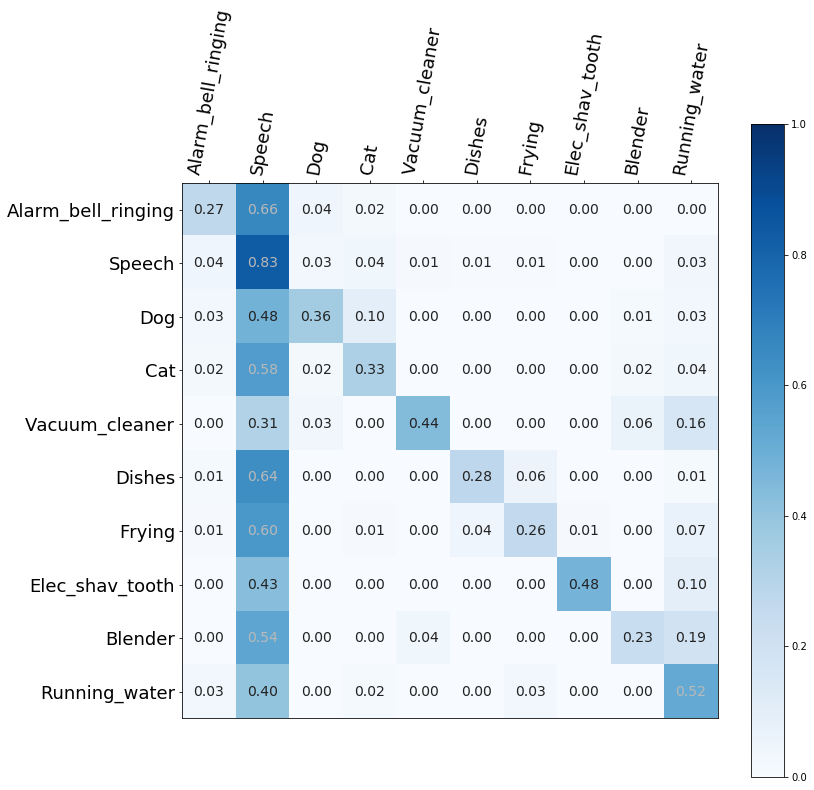

In [65]:
# ---- compute appprint(pred)roximative confusion matrix ----
true, pred = reshapeAndFormat(basic_predic, False)

confusion = confusion_matrix(true, pred, labels=classes)

# Normalize the confusion matrix using a sklearn MinMaxScaler
def scaleConfusion(confusion: np.array) -> np.array:
    scaledConfusion = []
    for line in confusion:
        scaledLine = line / sum(line)
        scaledConfusion.append(scaledLine)
        
    return scaledConfusion

def displayConfusion(matrix: np.array, classes: list, bcolor: str ="Blues", bounds: tuple = (0,1)):
    plt.figure(figsize=(12,12))
    #plt.title(os.path.basename(modelJsonPath))
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False

    plt.imshow(matrix)
    plt.xticks([i for i in range(len(classes))], classes, rotation=80)
    plt.yticks([i for i in range(len(classes))], classes)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=18)

    # add text on the matrix
    for i in range(len(classes)):
        for j in range(len(classes)):
            value = matrix[j][i]
            displayValue = "%.2f" % matrix[j][i]
            displayValue = displayValue[:]
            if value > 0.5: color="#b9b9b9"
            else: color="#232323"

            plt.text(i, j, displayValue, fontsize=14, color=color, ha="center", va="center")

    plt.set_cmap(bcolor)
    plt.clim(*bounds)
    plt.colorbar(cmap=bcolor)
    
scaledConfusion = scaleConfusion(confusion)
displayConfusion(scaledConfusion, classes)

In [28]:
confusionMatrices[os.path.basename(modelJsonPath)] = (confusion, scaledConfusion)

for key in confusionMatrices

oldMel_noBlank_reduce8_model.json
oldMel_noBlank_reduce4_model.json
oldMel_noBlank_reduce2_model.json
oldMel_noBlank_model.json


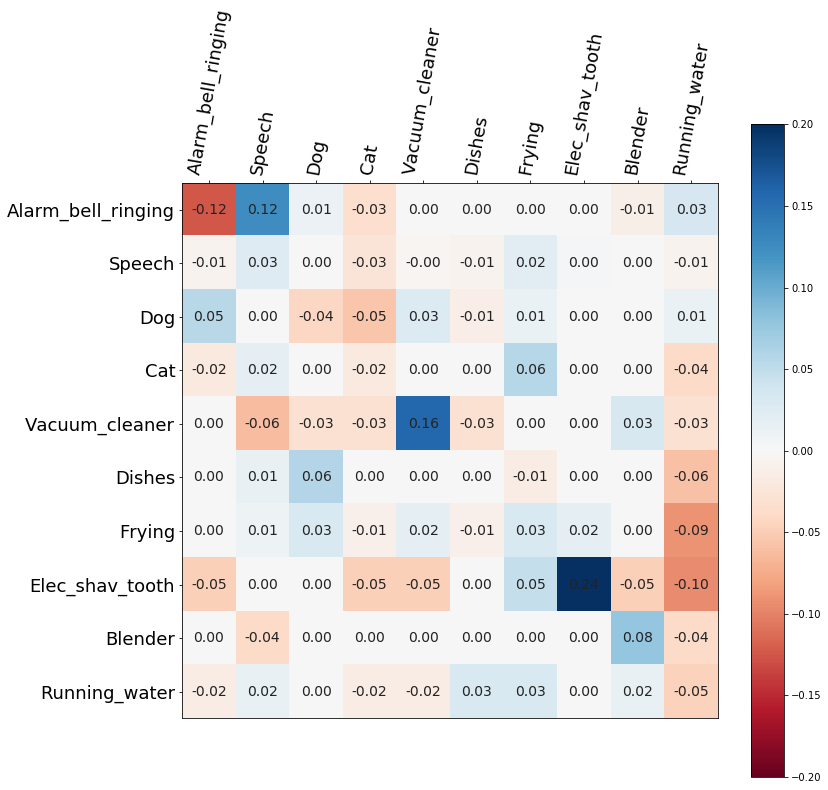

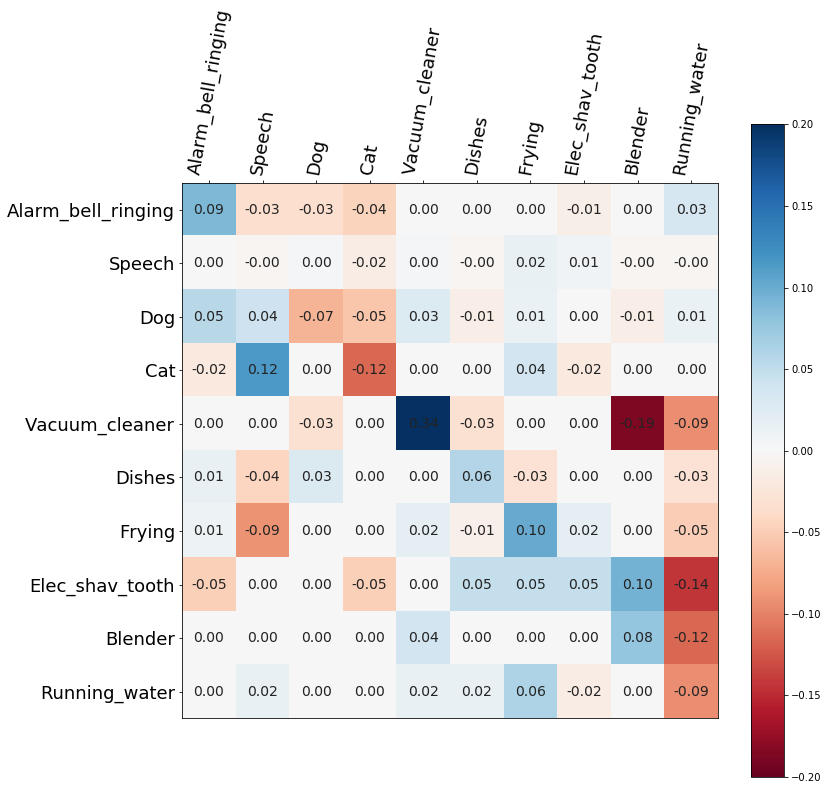

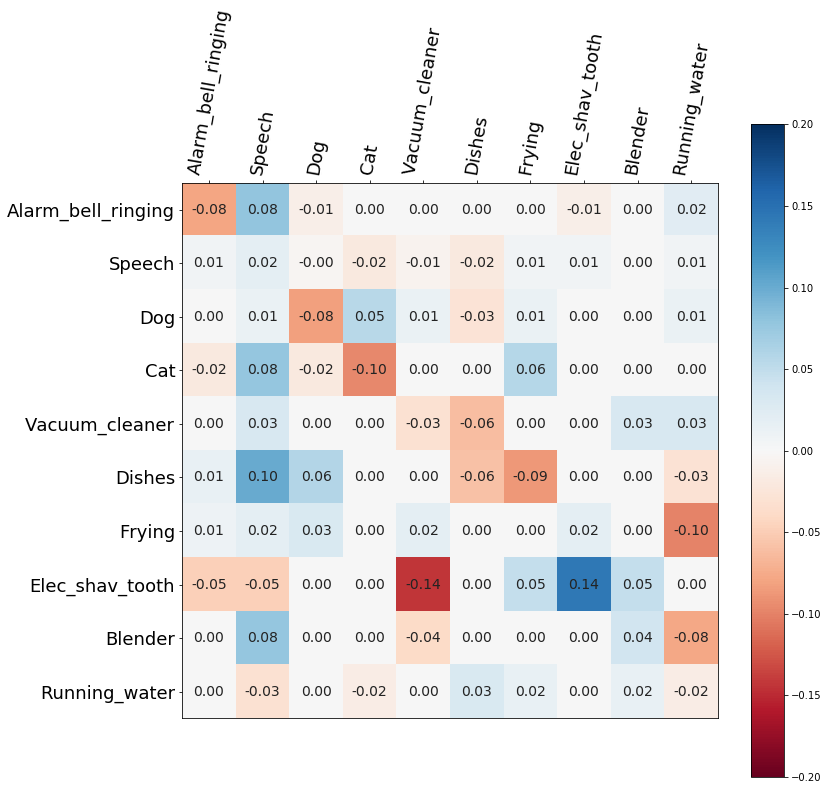

In [61]:
diff_normal_reduce2 = np.array(confusionMatrices["oldMel_noBlank_model.json"][1]) - np.array(confusionMatrices["oldMel_noBlank_reduce2_model.json"][1])
diff_normal_reduce4 = np.array(confusionMatrices["oldMel_noBlank_model.json"][1]) - np.array(confusionMatrices["oldMel_noBlank_reduce4_model.json"][1])
diff_normal_reduce8 = np.array(confusionMatrices["oldMel_noBlank_model.json"][1]) - np.array(confusionMatrices["oldMel_noBlank_reduce8_model.json"][1])

displayConfusion(diff_normal_reduce2, classes, bcolor="RdBu", bounds=(-0.20, 0.20))
displayConfusion(diff_normal_reduce4, classes, bcolor="RdBu", bounds=(-0.20, 0.20))
displayConfusion(diff_normal_reduce8, classes, bcolor="RdBu", bounds=(-0.20, 0.20))

# compute variance of the difference

# Compute ROC curve for each class

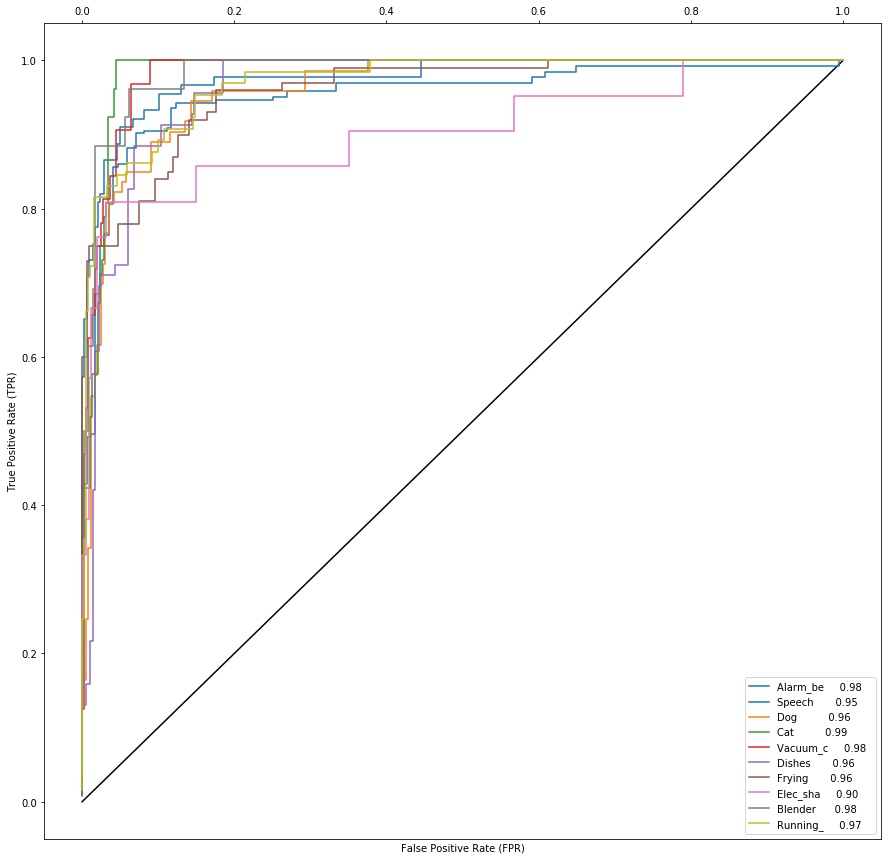

In [45]:
Colors = "C0,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,#ffff00".split(",")

fpr = dict()
tpr = dict()
score = dict()
for clsInd in range(len(classes)):
    cls = classes[clsInd]
    y_true = np.array(vTrue[:,clsInd])
    y_pred = np.array(prediction[:,clsInd])
    
    fpr[cls], tpr[cls], _ = roc_curve(y_true, y_pred, pos_label=1, drop_intermediate=True)
    score[cls] = auc(fpr[cls], tpr[cls])


plt.figure(figsize=(15, 15))
plt.subplot(111)
plt.plot([0,1], [0,1], color="black")

for clsInd in range(len(classes)):
    label = "%-*s %-*.2f" % (12, classes[clsInd][:8], 6, score[classes[clsInd]])
    fp = fpr[classes[clsInd]]
    tp = tpr[classes[clsInd]]
    plt.plot(fp, tp, color=Colors[clsInd], label=label)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.show()

# Compute confusion matrix using optimized threshold

In [ ]:
# Apply optimize threshold
optiPred = []
mappedScore = np.nan_to_num([score[key] for key in score])
print(prediction)
for i in range(len(prediction)):
    line = copy.copy(prediction[i])
    
    line[line > mappedScore] = 1
    line[line < mappedScore] = 0
    optiPred.append(line)
    
optiPred = np.array(optiPred, dtype=int)

# compute confusion matrix and scale it
true, pred = reshapeAndFormat(optiPred)
confusion = confusion_matrix(true, pred, labels=classes)
scaledConfusion = scaleConfusion(confusion)
displayConfusion(scaledConfusion, classes)

In [ ]:
precision = precision_score(vTrue, prediction, average=None)
recall = recall_score(vTrue, prediction, average=None)
f1 = f1_score(vTrue, prediction, average=None)

displayClasses = classes[:-1]
displayClasses.append("mean")
displayClasses.append("var")
displayClasses.append("std")

spacer = 10

print("%-*s" % (spacer, "std()), end="")
print("")classes:"), end="")
for cls in displayClasses:
    print("%-*s" % (spacer, cls[:spacer-2]), end="")
print("")
print("-" * (len(displayClasses)+1)*spacer)

print("%-*s" % (spacer, "precision:"), end="")
for i in range(len(precision)):
    print("%-*.3f" % (spacer, precision[i]), end="")
print("%-*.3f" % (spacer, precision.mean()), end="")
print("%-*.3f" % (spacer, precision.var()), end="")
print("%-*.3f" % (spacer, precision.std()), end="")
print("")

print("%-*s" % (spacer, "recall:"), end="")
for i in range(len(recall)):
    print("%-*.3f" % (spacer, recall[i]), end="")
print("%-*.3f" % (spacer, recall.mean()), end="")
print("%-*.3f" % (spacer, recall.var()), end="")
print("%-*.3f" % (spacer, recall.std()), end="")
print("")

print("%-*s" % (spacer, "f1:"), end="")
for i in range(len(f1)):
    print("%-*.3f" % (spacer, f1[i]), end="")
print("%-*.3f" % (spacer, f1.mean()), end="")
print("%-*.3f" % (spacer, f1.var()), end="")
print("%-*.3f" % (spacer, f1.std()), end="")
print("")    